In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os,sys
from scipy import stats
from collections import Counter
plt.style.use('seaborn-white')

plt.rcParams['figure.figsize']=4,3
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =0.5
plt.rcParams['lines.linewidth'] =0.5
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# set font size
SMALL_SIZE = 7
MEDIUM_SIZE = 8
LARGE_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=1) 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

plt.rcParams["xtick.bottom"] = True 
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.major.size"] = 4.0      
plt.rcParams["ytick.major.size"] = 4.0
plt.rcParams["xtick.major.width"] = 1
plt.rcParams["ytick.major.width"] = 1 

In [2]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as MLP
from xgboost import XGBClassifier as XGB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

# Machine learning

## JGOG internal validation

In [3]:
cnv_jgog=pd.read_csv('../../data/JGOG_282_ascat_spmg.CNV48.matrix.txt'
                     ,sep='\t',index_col=0)
cnv_jgog_r=cnv_jgog.apply(lambda x: x/np.sum(x),axis=1)
jgog_anno=pd.read_csv('../../data/JGOG_282_assigned_cluster.txt',sep='\t',index_col=0)
np.sum(cnv_jgog)

0:homdel:0-100kb        182
0:homdel:100kb-1Mb      995
0:homdel:>1Mb          1792
1:LOH:0-100kb           376
1:LOH:100kb-1Mb        2579
1:LOH:1Mb-10Mb         6567
1:LOH:10Mb-40Mb        4167
1:LOH:>40Mb             781
2:LOH:0-100kb           385
2:LOH:100kb-1Mb        3430
2:LOH:1Mb-10Mb         5748
2:LOH:10Mb-40Mb        1242
2:LOH:>40Mb             138
3-4:LOH:0-100kb         423
3-4:LOH:100kb-1Mb      2574
3-4:LOH:1Mb-10Mb       3482
3-4:LOH:10Mb-40Mb       740
3-4:LOH:>40Mb            55
5-8:LOH:0-100kb         142
5-8:LOH:100kb-1Mb       657
5-8:LOH:1Mb-10Mb        735
5-8:LOH:10Mb-40Mb       111
5-8:LOH:>40Mb             3
9+:LOH:0-100kb           34
9+:LOH:100kb-1Mb        139
9+:LOH:1Mb-10Mb          45
9+:LOH:10Mb-40Mb          1
9+:LOH:>40Mb              0
2:het:0-100kb           168
2:het:100kb-1Mb        2524
2:het:1Mb-10Mb         6385
2:het:10Mb-40Mb        3392
2:het:>40Mb            1136
3-4:het:0-100kb         595
3-4:het:100kb-1Mb      4935
3-4:het:1Mb-10Mb    

In [4]:
X=cnv_jgog_r.loc[jgog_anno.index,:]
y=jgog_anno['cluster_c_int']

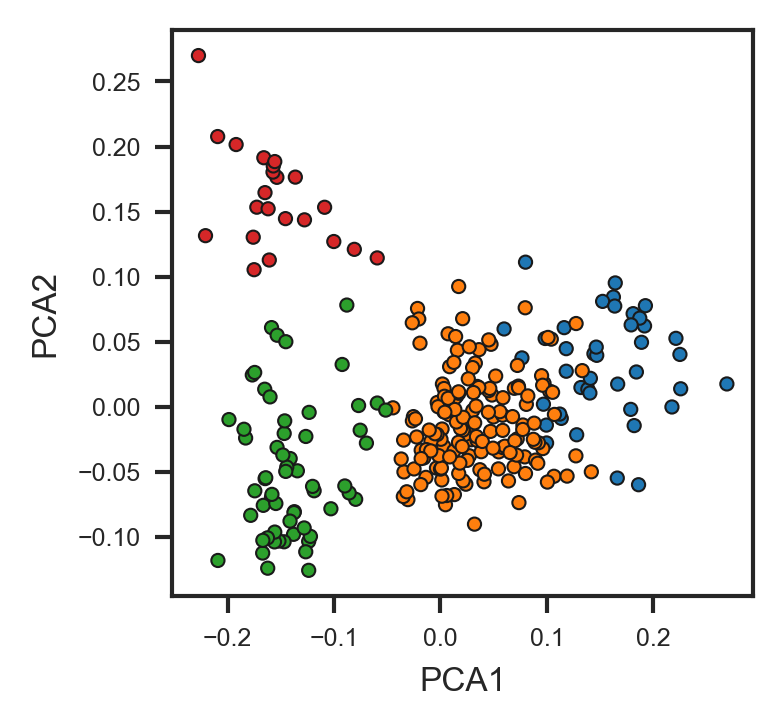

In [5]:
### pca
from sklearn.decomposition import PCA

data=X
pca =PCA(n_components=2)
pca.fit(data)
X2=pca.transform(data)

colors=y.replace({0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red'})

# plot
fig = plt.figure(figsize=(2.5,2.5))
ax = fig.add_subplot(1,1,1)    
ax.scatter(X2[:, 0], X2[:, 1],ec='k',fc=colors,s=10,lw=0.5)

ax.set_xlabel("PCA1",fontsize=8)
ax.set_ylabel("PCA2",fontsize=8)
ax.tick_params(labelsize=6)  

In [ ]:
loo = LeaveOneOut()
adds=[]

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    rc=RF(random_state=1,max_depth=3,class_weight='balanced')
    sc=SVC(random_state=1,class_weight='balanced')
    xc=XGB(random_state=1,use_label_encoder=False,eval_metric='mlogloss')
    kc=KN(n_neighbors=5)
    mc=MLP(random_state=1,max_iter=1000)
    
    rc.fit(X_train, y_train)
    xc.fit(X_train, y_train)
    sc.fit(X_train, y_train)
    kc.fit(X_train, y_train)
    mc.fit(X_train, y_train)
    
    y_pred_rc=rc.predict(X_test)
    y_pred_xc=xc.predict(X_test)
    y_pred_sc=sc.predict(X_test)
    y_pred_kc=kc.predict(X_test)
    y_pred_mc=mc.predict(X_test)
         
    add=pd.DataFrame(y_test)
    add['RFC']=y_pred_rc
    add['SVM']=y_pred_sc
    add['KNN']=y_pred_kc
    add['XGB']=y_pred_xc
    add['MLP']=y_pred_mc
    adds.append(add)

In [ ]:
tmp1=pd.concat(adds)
tmp1

In [ ]:
for clf in tmp1.columns[1:]:
    cm=pd.DataFrame(metrics.confusion_matrix(tmp1['cluster_c_int'],tmp1[clf]))
    cm.index=['C'+str(i) for i in range(1,5)]
    cm.columns=['pC'+str(i) for i in range(1,5)]
    print(clf)
    display(cm)
    acs=metrics.accuracy_score(tmp1['cluster_c_int'],tmp1[clf])
    print(acs)

# TCGA-OV

In [7]:
c_tcga=pd.read_csv('../../../tcga_ov_data_with_gm/TCGA-OV_clinical_genomic_info.txt'
                   ,sep='\t',index_col=0)

## Combat seq for CNV signature 

### before combat

In [11]:
cnv_tcga0=pd.read_csv('./TCGA-OV_555_ascat_spmg.CNV48.matrix.tsv'
                      ,sep='\t',index_col=0)
cnv_tcga_r0=cnv_tcga0.apply(lambda x: x/np.sum(x),axis=1)
cnv_jgog0=pd.read_csv('../../data/JGOG_282_ascat_spmg.CNV48.matrix.txt'
                     ,sep='\t',index_col=0)
cnv_jgog_r0=cnv_jgog0.apply(lambda x: x/np.sum(x),axis=1)

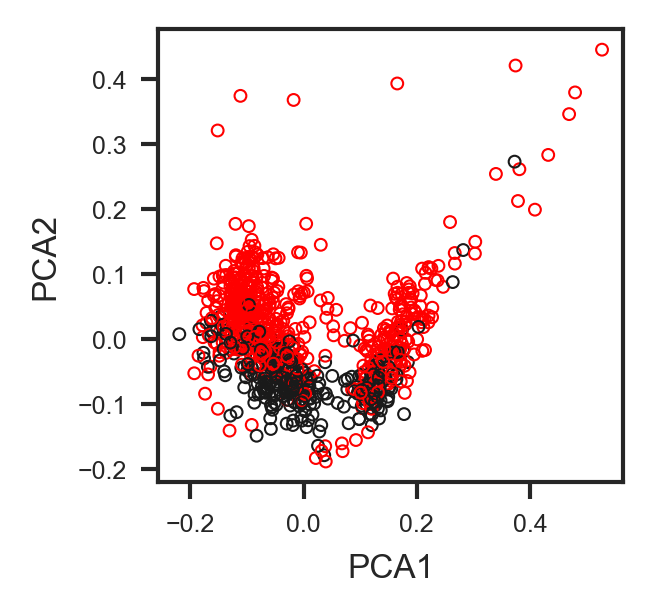

In [13]:
tmp_df=pd.concat([cnv_tcga_r0,cnv_jgog_r0])

data=tmp_df
pca =PCA(n_components=2)
pca.fit(data)

import random
order=random.sample(list(np.arange(data.shape[0])),data.shape[0])

X=pca.transform(data.iloc[order,:])

color_list=[0]*len(cnv_tcga0)+[1]*len(cnv_jgog0)
colors=pd.Series(color_list).replace({0:'red',1:'k',2:'b',3:'y',4:'purple',5:'brown',
                               6:'hotpink'})[order]

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(1,1,1)    
ax.scatter(X[:, 0], X[:, 1],ec=colors,fc="None",s=8,lw=0.5)

ax.set_xlabel("PCA1",fontsize=8)
ax.set_ylabel("PCA2",fontsize=8)
ax.tick_params(labelsize=6)  

### after combat, see combat.R

In [14]:
cnv_tcga=pd.read_csv('./TCGA-OV_555_ascat_spmg.CNV48.matrix.combat_to_JGOG.tsv'
                     ,sep='\t',index_col=0)
cnv_tcga_r=cnv_tcga.apply(lambda x: x/np.sum(x),axis=1)
np.sum(cnv_tcga)

0:homdel:0-100Kb        269
0:homdel:100Kb-1Mb      522
0:homdel:>1Mb           152
1:LOH:0-100Kb           435
1:LOH:100Kb-1Mb        1872
1:LOH:1Mb-10Mb         3861
1:LOH:10Mb-40Mb        3325
1:LOH:>40Mb            1064
2:LOH:0-100Kb           233
2:LOH:100Kb-1Mb        2112
2:LOH:1Mb-10Mb         4495
2:LOH:10Mb-40Mb        2610
2:LOH:>40Mb             898
3-4:LOH:0-100Kb         201
3-4:LOH:100Kb-1Mb      1774
3-4:LOH:1Mb-10Mb       3199
3-4:LOH:10Mb-40Mb      1547
3-4:LOH:>40Mb           441
5-8:LOH:0-100Kb         137
5-8:LOH:100Kb-1Mb       702
5-8:LOH:1Mb-10Mb        899
5-8:LOH:10Mb-40Mb       304
5-8:LOH:>40Mb            51
9+:LOH:0-100Kb           37
9+:LOH:100Kb-1Mb        169
9+:LOH:1Mb-10Mb         145
9+:LOH:10Mb-40Mb          8
9+:LOH:>40Mb              0
2:het:0-100Kb           169
2:het:100Kb-1Mb        1400
2:het:1Mb-10Mb         5100
2:het:10Mb-40Mb        4629
2:het:>40Mb            2463
3-4:het:0-100Kb         479
3-4:het:100Kb-1Mb      5641
3-4:het:1Mb-10Mb    

In [15]:
cnv_jgog=pd.read_csv('./JGOG_282_ascat_spmg.CNV48.matrix.combat_to_TCGA-OV.tsv'
                     ,sep='\t',index_col=0)
cnv_jgog_r=cnv_jgog.apply(lambda x: x/np.sum(x),axis=1)
np.sum(cnv_jgog)

0:homdel:0-100Kb        186
0:homdel:100Kb-1Mb     1029
0:homdel:>1Mb           502
1:LOH:0-100Kb           356
1:LOH:100Kb-1Mb        1991
1:LOH:1Mb-10Mb         3992
1:LOH:10Mb-40Mb        3600
1:LOH:>40Mb            1117
2:LOH:0-100Kb           383
2:LOH:100Kb-1Mb        2223
2:LOH:1Mb-10Mb         4313
2:LOH:10Mb-40Mb        2621
2:LOH:>40Mb             172
3-4:LOH:0-100Kb         412
3-4:LOH:100Kb-1Mb      1852
3-4:LOH:1Mb-10Mb       3052
3-4:LOH:10Mb-40Mb       948
3-4:LOH:>40Mb            75
5-8:LOH:0-100Kb         173
5-8:LOH:100Kb-1Mb       629
5-8:LOH:1Mb-10Mb       1237
5-8:LOH:10Mb-40Mb       240
5-8:LOH:>40Mb             3
9+:LOH:0-100Kb           43
9+:LOH:100Kb-1Mb        166
9+:LOH:1Mb-10Mb          94
9+:LOH:10Mb-40Mb          1
9+:LOH:>40Mb              0
2:het:0-100Kb           204
2:het:100Kb-1Mb        1559
2:het:1Mb-10Mb         4746
2:het:10Mb-40Mb        4252
2:het:>40Mb            1135
3-4:het:0-100Kb         570
3-4:het:100Kb-1Mb      5236
3-4:het:1Mb-10Mb    

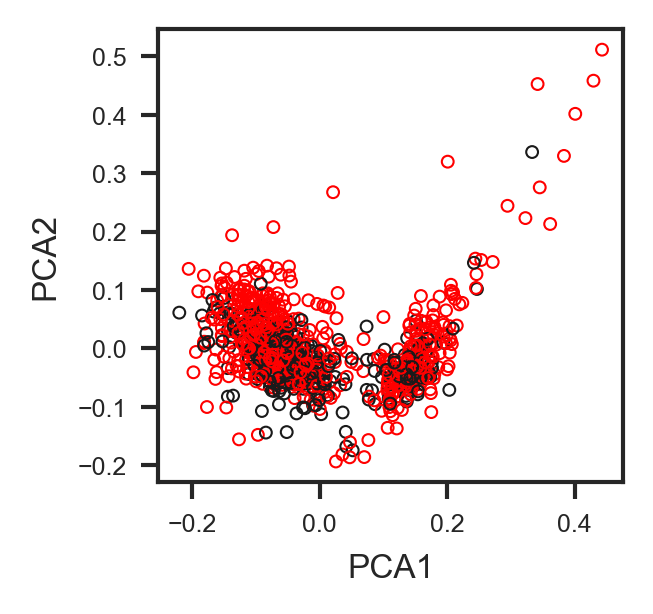

In [16]:
tmp_df=pd.concat([cnv_tcga_r,cnv_jgog_r])

data=tmp_df
pca =PCA(n_components=2)
pca.fit(data)

import random
order=random.sample(list(np.arange(data.shape[0])),data.shape[0])

X=pca.transform(data.iloc[order,:])

color_list=[0]*len(cnv_tcga)+[1]*len(cnv_jgog)
colors=pd.Series(color_list).replace({0:'red',1:'k'})[order]

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(1,1,1)    
ax.scatter(X[:, 0], X[:, 1],ec=colors,fc="None",s=8,lw=0.5)

ax.set_xlabel("PCA1",fontsize=8)
ax.set_ylabel("PCA2",fontsize=8)
ax.tick_params(labelsize=6)  

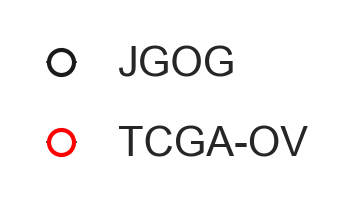

In [45]:
lg_colors=['k','red']
lg_labels=["JGOG","TCGA-OV"]
lg_number=2

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],marker='o',markerfacecolor='w',markeredgecolor=lg_colors[i],markersize=6,
                        label=lg_labels[i],
                        color="k"
                        ) for i in range(len(lg_labels))]
# plot
plt.figure(figsize=(1,0.5))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=0.7,ncol=1
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

## Test

In [147]:
X=cnv_jgog_r.loc[jgog_anno.index,:]
y=jgog_anno['cluster_c_int']

In [148]:
# Training
_RS=1
rc=RF(random_state=_RS,max_depth=3,class_weight='balanced')
sc=SVC(random_state=_RS,class_weight='balanced')
xc=XGB(random_state=_RS,use_label_encoder=False,eval_metric='mlogloss')
kc=KN(n_neighbors=5)
mc=MLP(random_state=_RS,max_iter=1000)

In [149]:
rc.fit(X,y)
sc.fit(X,y)
xc.fit(X,y)
kc.fit(X,y)
mc.fit(X,y)

MLPClassifier(max_iter=1000, random_state=1)

In [150]:
# Prediction
in_df=cnv_tcga_r
preds=pd.DataFrame(index=in_df.index)
preds['RC']=rc.predict(in_df) 
preds['SC']=sc.predict(in_df) 
preds['XC']=xc.predict(in_df) 
preds['KC']=kc.predict(in_df)
preds['MC']=mc.predict(in_df)

In [151]:
for col in preds.columns:
    print(col,Counter(preds[col]) )

RC Counter({1: 228, 2: 163, 0: 154, 3: 10})
SC Counter({1: 247, 2: 161, 0: 123, 3: 24})
XC Counter({1: 274, 0: 129, 2: 125, 3: 27})
KC Counter({1: 285, 2: 162, 0: 89, 3: 19})
MC Counter({1: 256, 2: 166, 0: 116, 3: 17})


In [152]:
# consensus
c3,c4,c5=[],[],[]
for idx in preds.index:
    tmp=preds.loc[idx,:]
    counter=Counter(tmp).most_common()
    common_label=counter[0][0]
    n_vote=counter[0][1]
    if n_vote>=3:
        c3.append('C'+str(common_label+1))
    else:
        c3.append('UD')
    if n_vote>=4:
        c4.append('C'+str(common_label+1))
    else:
        c4.append('UD')
    if n_vote>=5:
        c5.append('C'+str(common_label+1))
    else:
        c5.append('UD')

In [153]:
preds['P3']=c3
preds['P4']=c4
preds['P5']=c5

In [154]:
Counter(preds['P4'])


Counter({'UD': 50, 'C2': 235, 'C3': 157, 'C1': 101, 'C4': 12})

In [155]:
Counter(preds['P3'])


Counter({'C2': 258, 'C3': 161, 'C1': 115, 'C4': 20, 'UD': 1})

In [156]:
Counter(preds['P5'])


Counter({'UD': 160, 'C2': 189, 'C3': 119, 'C1': 79, 'C4': 8})

## Reapeat 100 times, using random seed 1-100, check the robustness of the results

In [157]:
X=cnv_jgog_r.loc[jgog_anno.index,:]
y=jgog_anno['cluster_c_int']
dict_sample_cluster_count3={}
dict_sample_cluster_count4={}
dict_sample_cluster_count5={}

for _RS in range(0,100):
    # Training
    rc=RF(random_state=_RS,max_depth=3,class_weight='balanced')
    sc=SVC(random_state=_RS,class_weight='balanced')
    xc=XGB(random_state=_RS,use_label_encoder=False,eval_metric='mlogloss')
    kc=KN(n_neighbors=5)
    mc=MLP(random_state=_RS,max_iter=1000)
    rc.fit(X,y)
    sc.fit(X,y)
    xc.fit(X,y)
    kc.fit(X,y)
    mc.fit(X,y)
    
    # Predict
    in_df=cnv_tcga_r
    preds=pd.DataFrame(index=in_df.index)
    preds['RC']=rc.predict(in_df) 
    preds['SC']=sc.predict(in_df) 
    preds['XC']=xc.predict(in_df) 
    preds['KC']=kc.predict(in_df)
    preds['MC']=mc.predict(in_df)
    
    # Consensus
    c3,c4,c5=[],[],[]
    for idx in preds.index:
        tmp=preds.loc[idx,:]
        counter=Counter(tmp).most_common()
        common_label=counter[0][0]
        n_vote=counter[0][1]
        if n_vote>=3:
            c3.append('C'+str(common_label+1))
        else:
            c3.append('UD')
        if n_vote>=4:
            c4.append('C'+str(common_label+1))
        else:
            c4.append('UD')
        if n_vote>=5:
            c5.append('C'+str(common_label+1))
        else:
            c5.append('UD')
    preds['P3']=c3
    preds['P4']=c4
    preds['P5']=c5
    if _RS==0:
        for idx in preds.index:
            dict_sample_cluster_count3[idx]={}
            dict_sample_cluster_count4[idx]={}
            dict_sample_cluster_count5[idx]={}
    
    # Repeat
    for idx in preds.index:
        p3=preds.loc[idx,'P3']
        p4=preds.loc[idx,'P4']
        p5=preds.loc[idx,'P5']
        if p3 not in dict_sample_cluster_count3[idx]:
            dict_sample_cluster_count3[idx][p3]=1
        else:
            dict_sample_cluster_count3[idx][p3]+=1
        if p4 not in dict_sample_cluster_count4[idx]:
            dict_sample_cluster_count4[idx][p4]=1
        else:
            dict_sample_cluster_count4[idx][p4]+=1
        if p5 not in dict_sample_cluster_count5[idx]:
            dict_sample_cluster_count5[idx][p5]=1
        else:
            dict_sample_cluster_count5[idx][p5]+=1

In [158]:
Counter(preds['RC'])

Counter({0: 143, 1: 234, 2: 165, 3: 13})

In [159]:
Counter(preds['KC'])

Counter({1: 285, 2: 162, 0: 89, 3: 19})

In [160]:
Counter(preds['SC'])

Counter({1: 247, 2: 161, 0: 123, 3: 24})

In [161]:
Counter(preds['XC'])

Counter({0: 129, 1: 274, 2: 125, 3: 27})

In [162]:
Counter(preds['MC'])

Counter({1: 256, 2: 164, 0: 117, 3: 18})

In [163]:
res3=pd.DataFrame(dict_sample_cluster_count3).fillna(0).T
Counter( res3['C4'] )

Counter({0.0: 534, 100.0: 19, 47.0: 1, 94.0: 1})

In [164]:
res4=pd.DataFrame(dict_sample_cluster_count4).fillna(0).T
Counter( res4['C4'] )

Counter({0.0: 539, 72.0: 1, 100.0: 12, 24.0: 1, 7.0: 1, 4.0: 1})

In [165]:
res5=pd.DataFrame(dict_sample_cluster_count5).fillna(0).T
Counter( res5['C4'] )

Counter({0.0: 544, 100.0: 6, 1.0: 1, 38.0: 1, 98.0: 1, 99.0: 1, 46.0: 1})

In [166]:
# Extract robust annotation in different random seeds
anno=[]
lim=50
for idx in res4.index:
    if res4.loc[idx,'C1']>lim:
        anno.append('C1')
    elif res4.loc[idx,'C2']>lim:
        anno.append('C2')
    elif res4.loc[idx,'C3']>lim:
        anno.append('C3')
    elif res4.loc[idx,'C4']>lim:
        anno.append('C4')
    else:
        anno.append('UD')
res4['P']=anno
Counter(anno)

Counter({'UD': 47, 'C2': 236, 'C3': 158, 'C1': 101, 'C4': 13})

In [167]:
preds.loc[:,'RC':'MC']

,RC,SC,XC,KC,MC
TCGA-04-1331,0,1,0,1,1
TCGA-04-1332,1,1,1,1,1
TCGA-04-1335,2,2,2,2,2
TCGA-04-1336,1,1,1,1,1
TCGA-04-1337,1,1,1,1,1
...,...,...,...,...,...
TCGA-61-2614,1,1,1,1,1
TCGA-OY-A56P,0,0,0,0,0
TCGA-OY-A56Q,0,0,0,0,0
TCGA-VG-A8LO,2,2,1,2,2


In [168]:
res=pd.merge(res4[['P']],preds.loc[:,'RC':'MC'],left_index=True,right_index=True,how='inner')
res

,P,RC,SC,XC,KC,MC
TCGA-04-1331,UD,0,1,0,1,1
TCGA-04-1332,C2,1,1,1,1,1
TCGA-04-1335,C3,2,2,2,2,2
TCGA-04-1336,C2,1,1,1,1,1
TCGA-04-1337,C2,1,1,1,1,1
...,...,...,...,...,...,...
TCGA-61-2614,C2,1,1,1,1,1
TCGA-OY-A56P,C1,0,0,0,0,0
TCGA-OY-A56Q,C1,0,0,0,0,0
TCGA-VG-A8LO,C3,2,2,1,2,2


In [169]:
res.to_csv('TCGA-OV_555_predicted_cluster.txt',sep='\t')

# TCGA-UCEC

## after combat, see combat.R

In [231]:
cnv_ov_ucec=pd.read_csv('./TCGA-OV-UCEC_842_ascat_spmg_CNV48.matrix.combat_to_JGOG.tsv'
                        ,sep='\t',index_col=0)
cnv_ov_ucec_r=cnv_ov_ucec.apply(lambda x: x/np.sum(x),axis=1)
cnv_jgog2=pd.read_csv('./JGOG_282_ascat_spmg.CNV48.matrix.combat_to_TCGA-OV-UCEC.tsv'
                     ,sep='\t',index_col=0)
cnv_jgog2_r=cnv_jgog2.apply(lambda x: x/np.sum(x),axis=1)

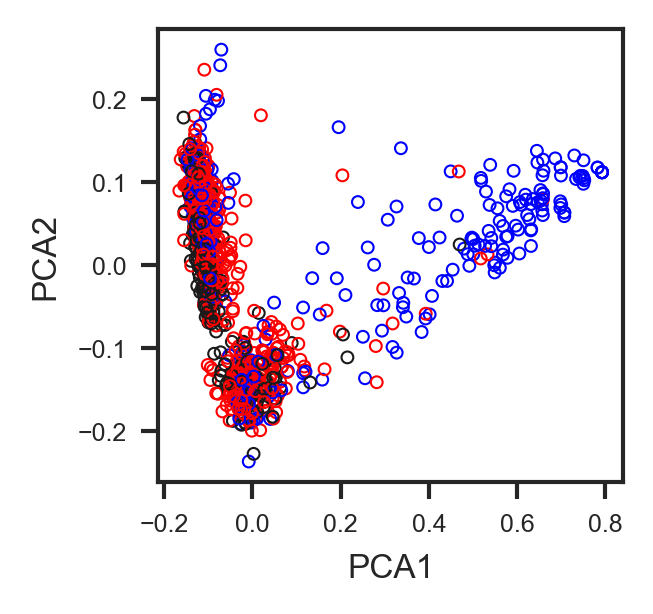

In [257]:
tmp_df=pd.concat([cnv_ov_ucec_r,cnv_jgog2_r])

data=tmp_df
pca =PCA(n_components=2)
pca.fit(data)

import random
order=random.sample(list(np.arange(data.shape[0])),data.shape[0])

X=pca.transform(data.iloc[order,:])

color_list=[0]*555+[1]*287+[2]*282
colors=pd.Series(color_list).replace({0:'red',1:'blue',2:'k'})
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(1,1,1)    
ax.scatter(X[:, 0], X[:, 1],ec=colors[order],fc="None",s=8,lw=0.5)

ax.set_xlabel("PCA1",fontsize=8)
ax.set_ylabel("PCA2",fontsize=8)
ax.tick_params(labelsize=6)  

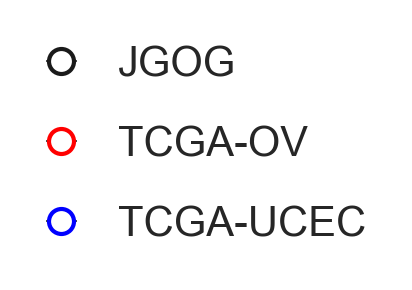

In [258]:
lg_colors=['k','red','blue']
lg_labels=["JGOG","TCGA-OV",'TCGA-UCEC']
lg_number=3

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],marker='o',markerfacecolor='w',markeredgecolor=lg_colors[i],markersize=6,
                        label=lg_labels[i],
                        color="k"
                        ) for i in range(len(lg_labels))]
# plot
plt.figure(figsize=(1,0.5))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=0.7,ncol=1
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

## Test

In [259]:
X=cnv_jgog2_r.loc[jgog_anno.index,:]
y=jgog_anno['cluster_c_int']

In [260]:
_RS=1
rc=RF(random_state=_RS,max_depth=3,class_weight='balanced')
sc=SVC(random_state=_RS,class_weight='balanced')
xc=XGB(random_state=_RS,use_label_encoder=False,eval_metric='mlogloss')
kc=KN(n_neighbors=5)
mc=MLP(random_state=_RS,max_iter=1000)

In [261]:
rc.fit(X,y)
sc.fit(X,y)
xc.fit(X,y)
kc.fit(X,y)
mc.fit(X,y)

MLPClassifier(max_iter=1000, random_state=1)

In [262]:
in_df=cnv_ov_ucec_r
preds=pd.DataFrame(index=in_df.index)
preds['RC']=rc.predict(in_df) 
preds['SC']=sc.predict(in_df) 
preds['XC']=xc.predict(in_df) 
preds['KC']=kc.predict(in_df)
preds['MC']=mc.predict(in_df)

In [263]:
for col in preds.columns:
    print(col,Counter(preds[col]) )

RC Counter({1: 336, 2: 198, 0: 185, 3: 123})
SC Counter({1: 314, 2: 192, 0: 169, 3: 167})
XC Counter({1: 368, 0: 176, 3: 165, 2: 133})
KC Counter({1: 391, 2: 193, 3: 154, 0: 104})
MC Counter({1: 342, 2: 192, 0: 155, 3: 153})


In [264]:
# Consensus
c3,c4,c5=[],[],[]
for idx in preds.index:
    tmp=preds.loc[idx,:]
    counter=Counter(tmp).most_common()
    common_label=counter[0][0]
    n_vote=counter[0][1]
    if n_vote>=3:
        c3.append('C'+str(common_label+1))
    else:
        c3.append('UD')

    if n_vote>=4:
        c4.append('C'+str(common_label+1))
    else:
        c4.append('UD')

    if n_vote>=5:
        c5.append('C'+str(common_label+1))
    else:
        c5.append('UD')
        

In [265]:
preds['P3']=c3
preds['P4']=c4
preds['P5']=c5


In [266]:
Counter(preds['P5'])


Counter({'C3': 109, 'C2': 248, 'UD': 277, 'C1': 91, 'C4': 117})

In [267]:
Counter(preds['P4'])


Counter({'C3': 178, 'C2': 305, 'C1': 129, 'UD': 90, 'C4': 140})

In [268]:
Counter(preds['P3'])


Counter({'C3': 196, 'C2': 337, 'C1': 154, 'C4': 153, 'UD': 2})

## Random seed 1-100, check the robustness of the results

In [269]:
dict_sample_cluster_count3={}
dict_sample_cluster_count4={}
dict_sample_cluster_count5={}

X=cnv_jgog2_r.loc[jgog_anno.index,:]
y=jgog_anno['cluster_c_int'] 

for _RS in range(0,100):
    # Training
    rc=RF(random_state=_RS,max_depth=3,class_weight='balanced')
    sc=SVC(random_state=_RS,class_weight='balanced')
    xc=XGB(random_state=_RS,use_label_encoder=False,eval_metric='mlogloss')
    kc=KN(n_neighbors=5)
    mc=MLP(random_state=_RS,max_iter=1000)
    rc.fit(X,y)
    sc.fit(X,y)
    xc.fit(X,y)
    kc.fit(X,y)
    mc.fit(X,y)
    
    # Prediction
    in_df=cnv_ov_ucec_r
    preds=pd.DataFrame(index=in_df.index)
    preds['RC']=rc.predict(in_df) 
    preds['SC']=sc.predict(in_df) 
    preds['XC']=xc.predict(in_df) 
    preds['KC']=kc.predict(in_df)
    preds['MC']=mc.predict(in_df)
    
    # Ensemble
    c3,c4,c5=[],[],[]
    for idx in preds.index:
        tmp=preds.loc[idx,:]
        counter=Counter(tmp).most_common()
        common_label=counter[0][0]
        n_vote=counter[0][1]
        if n_vote>=3:
            c3.append('C'+str(common_label+1))
        else:
            c3.append('UD')
        if n_vote>=4:
            c4.append('C'+str(common_label+1))
        else:
            c4.append('UD')
        if n_vote>=5:
            c5.append('C'+str(common_label+1))
        else:
            c5.append('UD')
    preds['P3']=c3
    preds['P4']=c4
    preds['P5']=c5
    if _RS==0:
        for idx in preds.index:
            dict_sample_cluster_count3[idx]={}
            dict_sample_cluster_count4[idx]={}
            dict_sample_cluster_count5[idx]={}
    
    for idx in preds.index:
        p3=preds.loc[idx,'P3']
        p4=preds.loc[idx,'P4']
        p5=preds.loc[idx,'P5']
        if p3 not in dict_sample_cluster_count3[idx]:
            dict_sample_cluster_count3[idx][p3]=1
        else:
            dict_sample_cluster_count3[idx][p3]+=1
        if p4 not in dict_sample_cluster_count4[idx]:
            dict_sample_cluster_count4[idx][p4]=1
        else:
            dict_sample_cluster_count4[idx][p4]+=1
        if p5 not in dict_sample_cluster_count5[idx]:
            dict_sample_cluster_count5[idx][p5]=1
        else:
            dict_sample_cluster_count5[idx][p5]+=1

In [270]:
Counter(preds['RC'])

Counter({2: 201, 1: 309, 0: 188, 3: 144})

In [271]:
Counter(preds['MC'])

Counter({2: 192, 1: 341, 0: 155, 3: 154})

In [272]:
Counter(preds['XC'])

Counter({2: 133, 1: 368, 0: 176, 3: 165})

In [273]:
Counter(preds['KC'])

Counter({2: 193, 1: 391, 0: 104, 3: 154})

In [274]:
Counter(preds['SC'])

Counter({2: 192, 1: 314, 0: 169, 3: 167})

In [275]:
res3=pd.DataFrame(dict_sample_cluster_count3).fillna(0).T
Counter( res3['C4'] )

Counter({0.0: 682,
         1.0: 1,
         12.0: 1,
         100.0: 151,
         98.0: 1,
         96.0: 1,
         43.0: 1,
         4.0: 1,
         2.0: 1,
         72.0: 1,
         16.0: 1})

In [276]:
res4=pd.DataFrame(dict_sample_cluster_count4).fillna(0).T
Counter( res4['C4'] )

Counter({0.0: 693,
         72.0: 1,
         100.0: 136,
         9.0: 1,
         4.0: 1,
         43.0: 1,
         27.0: 1,
         98.0: 1,
         12.0: 1,
         14.0: 1,
         54.0: 1,
         1.0: 1,
         3.0: 1,
         80.0: 1,
         63.0: 1})

In [277]:
res5=pd.DataFrame(dict_sample_cluster_count5).fillna(0).T
Counter(res5['C4'])

Counter({0.0: 708,
         100.0: 90,
         99.0: 14,
         97.0: 2,
         91.0: 2,
         50.0: 1,
         2.0: 1,
         98.0: 2,
         53.0: 1,
         15.0: 1,
         59.0: 1,
         92.0: 1,
         93.0: 1,
         89.0: 1,
         84.0: 1,
         1.0: 1,
         90.0: 1,
         82.0: 1,
         96.0: 2,
         94.0: 1,
         67.0: 1,
         41.0: 2,
         61.0: 1,
         87.0: 1,
         25.0: 1,
         3.0: 1,
         31.0: 1,
         40.0: 1})

In [278]:
anno=[]
lim=50
for idx in res4.index:
    if res4.loc[idx,'C1']>lim:
        anno.append('C1')
    elif res4.loc[idx,'C2']>lim:
        anno.append('C2')
    elif res4.loc[idx,'C3']>lim:
        anno.append('C3')
    elif res4.loc[idx,'C4']>lim:
        anno.append('C4')
    else:
        anno.append('UD')
res4['P']=anno
Counter(anno)

Counter({'C3': 178, 'C2': 302, 'C1': 132, 'UD': 89, 'C4': 141})

In [280]:
preds

,RC,SC,XC,KC,MC,P3,P4,P5
TCGA-23-2081,2,2,2,2,2,C3,C3,C3
TCGA-30-1714,1,1,1,1,1,C2,C2,C2
TCGA-09-1665,1,1,1,1,1,C2,C2,C2
TCGA-30-1892,1,1,1,1,1,C2,C2,C2
TCGA-24-2261,1,1,1,1,1,C2,C2,C2
...,...,...,...,...,...,...,...,...
TCGA-A5-A2K7,3,3,3,3,3,C4,C4,C4
TCGA-BG-A2L7,3,3,3,3,3,C4,C4,C4
TCGA-EY-A2OM,3,3,3,3,3,C4,C4,C4
TCGA-EO-A3B0,3,3,3,3,3,C4,C4,C4


In [255]:
res4['P'].to_csv('TCGA-OV-UCEC_842_predicted_cluster.txt',sep='\t')